In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json, requests
from datetime import datetime as dt
import random as rd
from geopy.geocoders import Nominatim
import re
import itertools

In [2]:
pd.set_option('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", None)
pd.options.mode.chained_assignment = None

In [3]:
def pretty_json(j):
    print(json.dumps(j, indent=2))

In [4]:
# http://dev.opentripplanner.org/apidoc/2.0.0/resource_PlannerResource.html
# http://docs.opentripplanner.org/en/latest/Configuration/#routing-modes
    
def OTP_API_get_plan(orig, dest, time=dt.now().strftime("%I:%M%p").lower(), date=dt.now().strftime("%m-%d-%Y"), mode='WALK,TRANSIT', numItineraries=1, maxWalkDistance=1000):

    query = f'fromPlace={orig[0]},{orig[1]}&toPlace={dest[0]},{dest[1]}&time={time}&date={date}&mode={mode}&numItineraries={numItineraries}&maxWalkDistance={maxWalkDistance}'
    url = f'http://127.0.0.1:8080/otp/routers/default/plan?{query}'
    try:
        return json.loads(requests.get(url).text)
    except IOError as err:
        errno, strerror = err.args
        print(f'I/O error({errno}): {strerror}')
    except ValueError:
        print('No JSON object could be decoded')
    except:
        print(f'Unexpected error: {sys.exc_info()[0]}')
    
    return None

In [5]:
%%script false --no-raise-error

# TEST : saclay - orly
plan = OTP_API_get_plan((48.86697, 2.37167), (48.83489, 2.28310))
pretty_json(plan)

In [6]:
# Bounding box GPE : 2.070163,48.707927,2.595584,49.027041

def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

def get_rand_coords():
    lat = truncate(rd.uniform(48.707927, 49.027041), decimals=6)
    lon = truncate(rd.uniform(2.070163, 2.595584), decimals=6)
    return (lat, lon)

In [7]:
# https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula"

def distance(lat1, lon1, lat2, lon2):
    p = np.pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p) * np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p))/2
    return 12742 * np.arcsin(np.sqrt(a))

In [8]:
# https://pypi.org/project/geopy/
# pip install geopy
# conda install -c conda-forge geopy
# https://www.data.gouv.fr/en/datasets/base-officielle-des-codes-postaux/

df_zipcodes = pd.read_csv(f'./data/laposte_hexasmal.csv', delimiter=';')

def get_adress(x, y):
    return Nominatim(user_agent="my-app").reverse(f"{x} {y}").address

def get_zipcode(adress):
    zipcode = re.findall(r"\b\d{5}\b", adress)
    return int(zipcode[0]) if len(zipcode) > 0 else 0

def get_commune(zipcode):
    return next(iter(df_zipcodes.loc[df_zipcodes["Code_postal"] == zipcode, "Nom_commune"].values), "")

def get_departement(zipcode):
    return {
        "75": "PARIS",
        "77": "SEINE-ET-MARNE",
        "78": "YVELINES",
        "91": "ESSONE",
        "92": "HAUTS-DE-SEINE",
        "93": "SEINE-SAINT-DENIS",
        "94": "VAL-DE-MARNE",
        "95": "VAL-D'OISE"
    }[str(zipcode)[:2]]

def get_location(lat, lon):
    zipcode = get_zipcode(get_adress(lat, lon))
    return {
        "lat": lat,
        "lon": lon,
        "zipcode": zipcode,
        "commune": (get_commune(zipcode) if zipcode > 0 else ""),
        "departement": (get_departement(zipcode) if zipcode > 0 else "")
    }

In [9]:
def add_itinerary(orig, dest, mode, df_itineraries_):
    plan = OTP_API_get_plan(orig, dest, mode=mode, maxWalkDistance=('' if mode == 'CAR' else 1000))
    itinerary = next(iter(plan["plan"]["itineraries"]), None)
    coeff = 1.7 if mode == 'CAR' else 1.0
    return pd.concat([
        df_itineraries_,
        pd.DataFrame({
            "origin": [json.dumps(get_location(orig[0], orig[1]))],
            "destination": [json.dumps(get_location(dest[0], dest[1]))],
            "distance": [distance(dest[0], dest[1], orig[0], orig[1])],
            "mode": mode,
            "duration": [float(itinerary["duration"] if itinerary else 0)*coeff],
            "walktime": [float(itinerary["walkTime"] if itinerary  and not mode == 'CAR' else 0)],
            "transfers": [float(itinerary["transfers"] if itinerary and not mode == 'CAR' else 0)],
            "route": [json.dumps(
                ([{"mode": legs["mode"], "route": legs["route"], "agencyName": legs["agencyName"]}
                  for legs in itinerary["legs"] if not legs["mode"] == "WALK"] 
                 if itinerary and not mode == 'CAR' else [])
            )]
        })
    ], axis=0, ignore_index=True)

In [10]:
def get_coords(n):
    return [(get_rand_coords(), get_rand_coords()) for _ in range(n)]

def get_itineraries(coords_):
    
    df_itineraries_ = pd.DataFrame({
        "origin": [],
        "destination": [],
        "distance": [],
        "mode": [],
        "duration": [],
        "walktime": [],
        "transfers": [],
        "route": []
    })
    
    for i, c in enumerate(coords_):
        print(f"# {i+1} : lat={c[0]}, lon={c[1]}")
        df_itineraries_ = add_itinerary(c[0], c[1], 'WALK,TRANSIT', df_itineraries_)
        df_itineraries_ = add_itinerary(c[0], c[1], 'CAR', df_itineraries_)
        
    return df_itineraries_

In [11]:
def write_csv(df, name):
    df.loc[
        (df["origin"].map(lambda o: json.loads(o)["zipcode"] > 0)) &
        (df["destination"].map(lambda d: json.loads(d)["zipcode"] > 0)) &
        (df["duration"] > 0) & 
        (df["duration"] < 20000)
    ].reset_index(drop=True). \
    to_csv(f'./data/{name}.csv', sep = ';')
    
def read_csv(name):
    df = pd.read_csv(f'./data/{name}.csv', delimiter=';', index_col=0)
    for column in ["origin", "destination", "route"]:
        df[column] = df[column].map(lambda r: json.loads(r))
    return df

In [12]:
coords = get_coords(1000)

In [13]:
%%script false --no-raise-error
write_csv(get_itineraries(coords), "idf")

In [14]:
%%script false --no-raise-error
write_csv(get_itineraries(coords), "gpe-idf")

In [15]:
df_itineraries_idf = read_csv("idf")
df_itineraries_idf.head(10)

,origin,destination,distance,mode,duration,walktime,transfers,route
0,"{'lat': 48.726033, 'lon': 2.425854, 'zipcode': 94480, 'commune': 'ABLON SUR SEINE', 'departement': 'VAL-DE-MARNE'}","{'lat': 48.70967, 'lon': 2.352844, 'zipcode': 77240, 'commune': 'CESSON', 'departement': 'SEINE-ET-MARNE'}",5.656818,"WALK,TRANSIT",2758.0,1138.0,1.0,"[{'mode': 'RAIL', 'route': 'C', 'agencyName': 'RER'}, {'mode': 'BUS', 'route': '399', 'agencyName': 'RATP'}]"
1,"{'lat': 48.726033, 'lon': 2.425854, 'zipcode': 94480, 'commune': 'ABLON SUR SEINE', 'departement': 'VAL-DE-MARNE'}","{'lat': 48.70967, 'lon': 2.352844, 'zipcode': 77240, 'commune': 'CESSON', 'departement': 'SEINE-ET-MARNE'}",5.656818,CAR,2463.3,0.0,0.0,[]
2,"{'lat': 48.989001, 'lon': 2.22563, 'zipcode': 95130, 'commune': 'FRANCONVILLE', 'departement': 'VAL-D'OISE'}","{'lat': 48.963119, 'lon': 2.562747, 'zipcode': 93290, 'commune': 'TREMBLAY EN FRANCE', 'departement': 'SEINE-SAINT-DENIS'}",24.772371,"WALK,TRANSIT",6690.0,1156.0,3.0,"[{'mode': 'BUS', 'route': '95-29', 'agencyName': 'Valoise'}, {'mode': 'RAIL', 'route': 'H', 'agencyName': 'TRAIN'}, {'mode': 'RAIL', 'route': 'B', 'agencyName': 'RER'}, {'mode': 'BUS', 'route': '619', 'agencyName': 'Seine-Saint-Denis'}]"
3,"{'lat': 48.989001, 'lon': 2.22563, 'zipcode': 95130, 'commune': 'FRANCONVILLE', 'departement': 'VAL-D'OISE'}","{'lat': 48.963119, 'lon': 2.562747, 'zipcode': 93290, 'commune': 'TREMBLAY EN FRANCE', 'departement': 'SEINE-SAINT-DENIS'}",24.772371,CAR,3026.0,0.0,0.0,[]
4,"{'lat': 48.847823, 'lon': 2.575918, 'zipcode': 93160, 'commune': 'NOISY LE GRAND', 'departement': 'SEINE-SAINT-DENIS'}","{'lat': 48.740238, 'lon': 2.181706, 'zipcode': 91400, 'commune': 'ORSAY', 'departement': 'ESSONE'}",31.256527,"WALK,TRANSIT",6974.0,2268.0,2.0,"[{'mode': 'RAIL', 'route': 'A', 'agencyName': 'RER'}, {'mode': 'RAIL', 'route': 'B', 'agencyName': 'RER'}, {'mode': 'BUS', 'route': '9', 'agencyName': 'Cars D'Orsay'}]"
5,"{'lat': 48.847823, 'lon': 2.575918, 'zipcode': 93160, 'commune': 'NOISY LE GRAND', 'departement': 'SEINE-SAINT-DENIS'}","{'lat': 48.740238, 'lon': 2.181706, 'zipcode': 91400, 'commune': 'ORSAY', 'departement': 'ESSONE'}",31.256527,CAR,4505.0,0.0,0.0,[]
6,"{'lat': 48.782309, 'lon': 2.190531, 'zipcode': 78140, 'commune': 'VELIZY VILLACOUBLAY', 'departement': 'YVELINES'}","{'lat': 48.720788, 'lon': 2.493697, 'zipcode': 91330, 'commune': 'YERRES', 'departement': 'ESSONE'}",23.255112,"WALK,TRANSIT",7165.0,1277.0,3.0,"[{'mode': 'TRAM', 'route': 'Châtillon Montrouge - Gare de Viroflay Rive Droite', 'agencyName': 'TRAMWAY'}, {'mode': 'RAIL', 'route': 'C', 'agencyName': 'RER'}, {'mode': 'RAIL', 'route': 'D', 'agencyName': 'RER'}, {'mode': 'BUS', 'route': 'B', 'agencyName': 'STRAV'}]"
7,"{'lat': 48.782309, 'lon': 2.190531, 'zipcode': 78140, 'commune': 'VELIZY VILLACOUBLAY', 'departement': 'YVELINES'}","{'lat': 48.720788, 'lon': 2.493697, 'zipcode': 91330, 'commune': 'YERRES', 'departement': 'ESSONE'}",23.255112,CAR,4583.2,0.0,0.0,[]
8,"{'lat': 48.759455, 'lon': 2.420124, 'zipcode': 94600, 'commune': 'CHOISY LE ROI', 'departement': 'VAL-DE-MARNE'}","{'lat': 48.723814, 'lon': 2.56474, 'zipcode': 94440, 'commune': 'MAROLLES EN BRIE', 'departement': 'VAL-DE-MARNE'}",11.320768,"WALK,TRANSIT",3790.0,983.0,2.0,"[{'mode': 'BUS', 'route': 'A', 'agencyName': 'VyBus'}, {'mode': 'BUS', 'route': 'J2', 'agencyName': 'STRAV'}, {'mode': 'BUS', 'route': '21', 'agencyName': 'Arlequin'}]"
9,"{'lat': 48.759455, 'lon': 2.420124, 'zipcode': 94600, 'commune': 'CHOISY LE ROI', 'departement': 'VAL-DE-MARNE'}","{'lat': 48.723814, 'lon': 2.56474, 'zipcode': 94440, 'commune': 'MAROLLES EN BRIE', 'departement': 'VAL-DE-MARNE'}",11.320768,CAR,3202.8,0.0,0.0,[]


In [16]:
df_itineraries_gpe_idf = read_csv("gpe-idf")
df_itineraries_gpe_idf.head(10)

,origin,destination,distance,mode,duration,walktime,transfers,route
0,"{'lat': 48.726033, 'lon': 2.425854, 'zipcode': 94480, 'commune': 'ABLON SUR SEINE', 'departement': 'VAL-DE-MARNE'}","{'lat': 48.70967, 'lon': 2.352844, 'zipcode': 77240, 'commune': 'CESSON', 'departement': 'SEINE-ET-MARNE'}",5.656818,"WALK,TRANSIT",3334.0,1774.0,2.0,"[{'mode': 'BUS', 'route': '487', 'agencyName': 'RATP'}, {'mode': 'BUS', 'route': '399', 'agencyName': 'RATP'}, {'mode': 'BUS', 'route': '486', 'agencyName': 'RATP'}]"
1,"{'lat': 48.726033, 'lon': 2.425854, 'zipcode': 94480, 'commune': 'ABLON SUR SEINE', 'departement': 'VAL-DE-MARNE'}","{'lat': 48.70967, 'lon': 2.352844, 'zipcode': 77240, 'commune': 'CESSON', 'departement': 'SEINE-ET-MARNE'}",5.656818,CAR,3502.0,0.0,0.0,[]
2,"{'lat': 48.989001, 'lon': 2.22563, 'zipcode': 95130, 'commune': 'FRANCONVILLE', 'departement': 'VAL-D'OISE'}","{'lat': 48.963119, 'lon': 2.562747, 'zipcode': 93290, 'commune': 'TREMBLAY EN FRANCE', 'departement': 'SEINE-SAINT-DENIS'}",24.772371,"WALK,TRANSIT",6781.0,2807.0,4.0,"[{'mode': 'RAIL', 'route': 'C', 'agencyName': 'RER'}, {'mode': 'SUBWAY', 'route': '15', 'agencyName': 'METRO'}, {'mode': 'SUBWAY', 'route': '16', 'agencyName': 'METRO'}, {'mode': 'BUS', 'route': '100', 'agencyName': 'KMR'}, {'mode': 'BUS', 'route': '619', 'agencyName': 'Seine-Saint-Denis'}]"
3,"{'lat': 48.989001, 'lon': 2.22563, 'zipcode': 95130, 'commune': 'FRANCONVILLE', 'departement': 'VAL-D'OISE'}","{'lat': 48.963119, 'lon': 2.562747, 'zipcode': 93290, 'commune': 'TREMBLAY EN FRANCE', 'departement': 'SEINE-SAINT-DENIS'}",24.772371,CAR,3026.0,0.0,0.0,[]
4,"{'lat': 48.819548, 'lon': 2.43888, 'zipcode': 75012, 'commune': 'PARIS 12', 'departement': 'PARIS'}","{'lat': 48.943643, 'lon': 2.102372, 'zipcode': 78100, 'commune': 'ST GERMAIN EN LAYE', 'departement': 'YVELINES'}",28.211579,"WALK,TRANSIT",6100.0,1680.0,1.0,"[{'mode': 'BUS', 'route': '77', 'agencyName': 'RATP'}, {'mode': 'RAIL', 'route': 'A', 'agencyName': 'RER'}]"
5,"{'lat': 48.819548, 'lon': 2.43888, 'zipcode': 75012, 'commune': 'PARIS 12', 'departement': 'PARIS'}","{'lat': 48.943643, 'lon': 2.102372, 'zipcode': 78100, 'commune': 'ST GERMAIN EN LAYE', 'departement': 'YVELINES'}",28.211579,CAR,6975.1,0.0,0.0,[]
6,"{'lat': 48.847823, 'lon': 2.575918, 'zipcode': 93160, 'commune': 'NOISY LE GRAND', 'departement': 'SEINE-SAINT-DENIS'}","{'lat': 48.740238, 'lon': 2.181706, 'zipcode': 91400, 'commune': 'ORSAY', 'departement': 'ESSONE'}",31.256527,"WALK,TRANSIT",6729.0,2968.0,3.0,"[{'mode': 'SUBWAY', 'route': '15', 'agencyName': 'METRO'}, {'mode': 'SUBWAY', 'route': '14', 'agencyName': 'METRO'}, {'mode': 'SUBWAY', 'route': '18', 'agencyName': 'METRO'}, {'mode': 'BUS', 'route': '9', 'agencyName': 'Cars D'Orsay'}]"
7,"{'lat': 48.847823, 'lon': 2.575918, 'zipcode': 93160, 'commune': 'NOISY LE GRAND', 'departement': 'SEINE-SAINT-DENIS'}","{'lat': 48.740238, 'lon': 2.181706, 'zipcode': 91400, 'commune': 'ORSAY', 'departement': 'ESSONE'}",31.256527,CAR,3864.1,0.0,0.0,[]
8,"{'lat': 48.782309, 'lon': 2.190531, 'zipcode': 78140, 'commune': 'VELIZY VILLACOUBLAY', 'departement': 'YVELINES'}","{'lat': 48.720788, 'lon': 2.493697, 'zipcode': 91330, 'commune': 'YERRES', 'departement': 'ESSONE'}",23.255112,"WALK,TRANSIT",7036.0,1362.0,4.0,"[{'mode': 'TRAM', 'route': 'Châtillon Montrouge - Gare de Viroflay Rive Droite', 'agencyName': 'TRAMWAY'}, {'mode': 'RAIL', 'route': 'C', 'agencyName': 'RER'}, {'mode': 'RAIL', 'route': 'B', 'agencyName': 'RER'}, {'mode': 'RAIL', 'route': 'D', 'agencyName': 'RER'}, {'mode': 'BUS', 'route': 'B', 'agencyName': 'STRAV'}]"
9,"{'lat': 48.782309, 'lon': 2.190531, 'zipcode': 78140, 'commune': 'VELIZY VILLACOUBLAY', 'departement': 'YVELINES'}","{'lat': 48.720788, 'lon': 2.493697, 'zipcode': 91330, 'commune': 'YERRES', 'departement': 'ESSONE'}",23.255112,CAR,4583.2,0.0,0.0,[]


In [17]:
def averages(df_itineraries_, idx):
    df_itineraries_ = df_itineraries_.loc[df_itineraries_["mode"] == "WALK,TRANSIT"]
    return pd.DataFrame({
        "Trips found" : [len(df_itineraries_)],
        "Duration" : [round(df_itineraries_["duration"].mean(), 2)],
        "Transfers" : [round(df_itineraries_["transfers"].mean(), 2)],
        "Distance" : [round(df_itineraries_["distance"].mean(), 2)],
        "Walktime" : [round(df_itineraries_["walktime"].mean(), 2)]
    }, index=[idx])

In [18]:
def plot_metrics_by_epoch(df_itineraries_idf_, df_itineraries_gpe_idf_, area):
    df_averages = pd.concat([
        averages(df_itineraries_idf_, f"{area} IDF now"),
        averages(df_itineraries_gpe_idf_, f"{area} IDF GPE")
    ])
    df_averages.index.names = ["epoch"]
    
    display(df_averages)
    
    columns = df_averages.columns.values.tolist()
    
    fig, axes = plt.subplots(5, 1, figsize=(20, 10))
    fig.suptitle(f'{area} Transit metrics before/after', fontsize=24)
    for e, c in enumerate(columns):
        sns.barplot(ax=axes[e], x=c, y="epoch", data=df_averages.reset_index(), saturation=.5)
        axes[e].set_ylabel(c)
        axes[e].set_xlabel("")
    None

,Trips found,Duration,Transfers,Distance,Walktime
epoch,,,,,
IDF now,726,5092.29,2.28,18.03,1352.56
IDF GPE,875,4738.00,2.17,18.84,1533.34


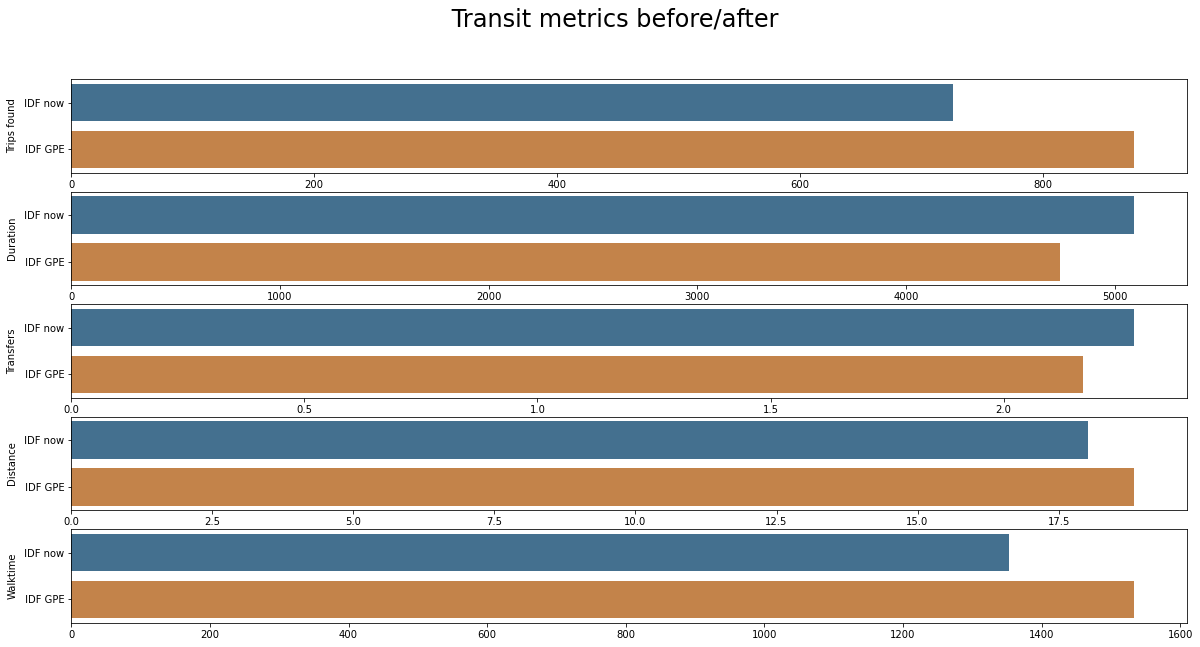

In [19]:
plot_metrics_by_epoch(df_itineraries_idf, df_itineraries_gpe_idf, "")

In [20]:
def plot_itineraries_hist_by_mode(df_itineraries_, title):
    plt.figure(figsize=(20, 10))
    sns.histplot(data=df_itineraries_, x="duration", hue="mode", kde=True, element="step")
    plt.title(f'{title}', fontsize=24)
    None

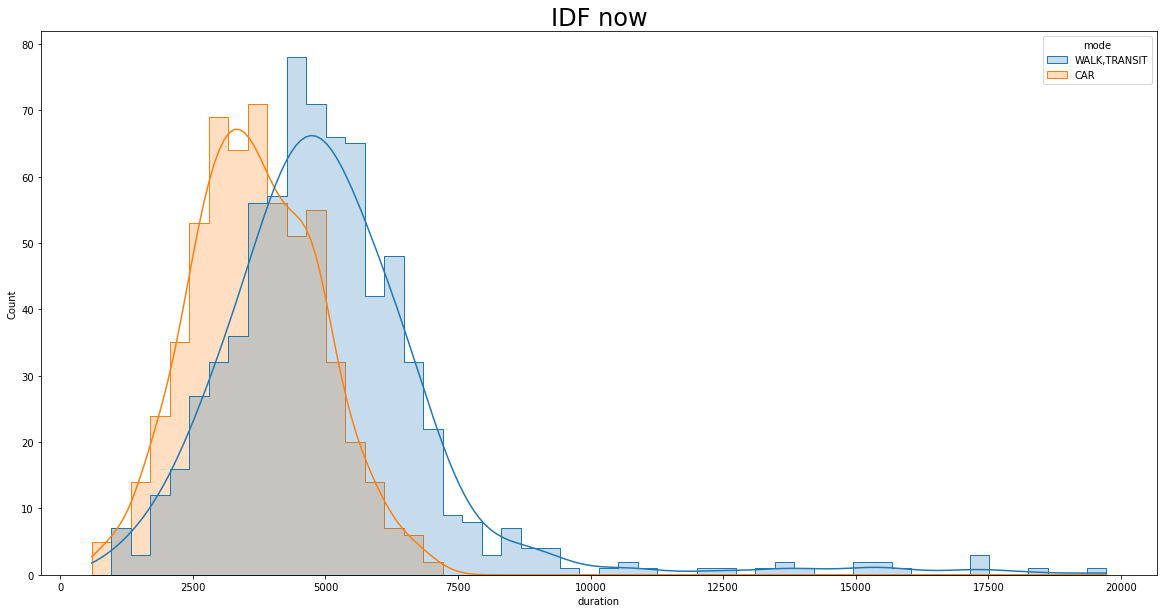

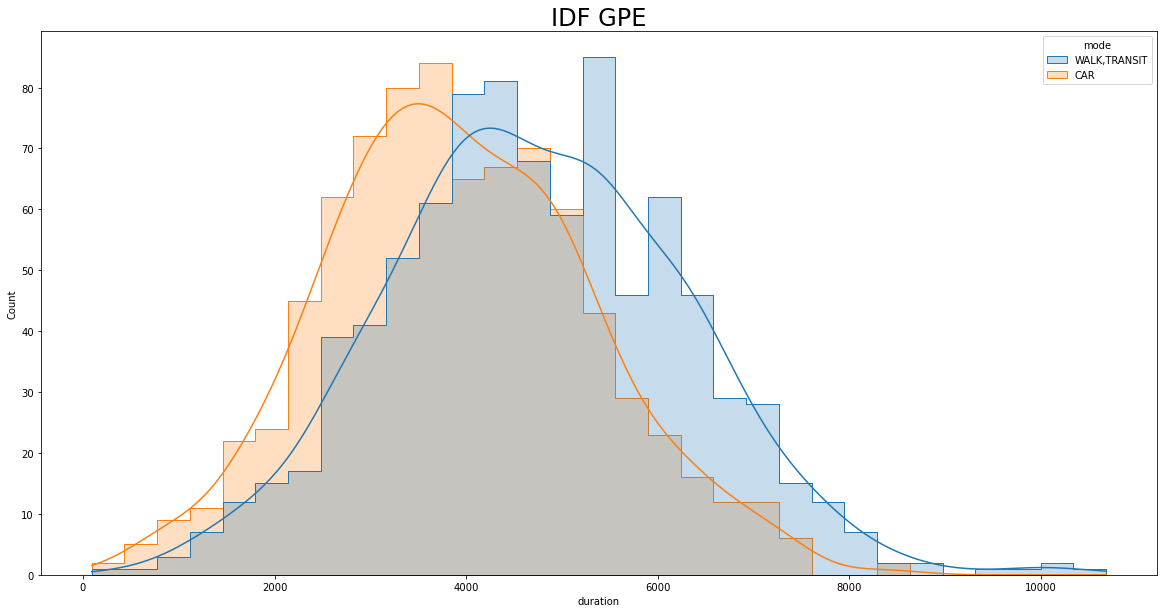

In [21]:
plot_itineraries_hist_by_mode(df_itineraries_idf, "IDF now")
plot_itineraries_hist_by_mode(df_itineraries_gpe_idf, "IDF GPE")

In [22]:
def get_modes(df_itineraries_):
    return pd.DataFrame([
        [
            sr["agencyName"] if sr["agencyName"] in ["TRAIN", "RER", "METRO", "TRAMWAY"] else sr["mode"],
            sr["route"]
        ] for sr in [
            subroute for route in [
                routes for routes in 
                df_itineraries_.loc[df_itineraries_["route"].map(lambda r: len(r)) > 0, ["route"]]["route"].values
            ] for subroute in route
        ]
    ], columns = ["mode", "route"]). \
    sort_values("mode", ignore_index=True)

In [23]:
df_modes_idf = get_modes(df_itineraries_idf)
df_modes_idf.head(10)

,mode,route
0,BUS,185
1,BUS,J2
2,BUS,378
3,BUS,R4
4,BUS,151
5,BUS,2
6,BUS,22
7,BUS,8
8,BUS,393
9,BUS,100


In [24]:
df_modes_gpe_idf = get_modes(df_itineraries_gpe_idf)
df_modes_gpe_idf.head(10)

,mode,route
0,BUS,487
1,BUS,112
2,BUS,289
3,BUS,23
4,BUS,179
5,BUS,30-05
6,BUS,17A
7,BUS,164
8,BUS,610
9,BUS,114


In [25]:
print("IDF now:", list(df_modes_idf["mode"].unique()))
print("IDF GPE:", list(df_modes_gpe_idf["mode"].unique()))

IDF now: ['BUS', 'FUNICULAR', 'METRO', 'RER', 'TRAIN', 'TRAMWAY']
IDF GPE: ['BUS', 'FUNICULAR', 'METRO', 'RAIL', 'RER', 'TRAIN', 'TRAMWAY']


In [26]:
def percentage_by_column(column, df):
    return pd.merge(
        df.groupby(column)[column].count().reset_index(name='Percentage').set_index(column). \
        apply(lambda Percentage: 100 * Percentage / float(Percentage.sum())).round({'Percentage': 2}),
        df.groupby(column)[column].count().reset_index(name='Count').set_index(column),
        how="left",
        on=column
    ).sort_values(['Count'], ascending=False)

In [27]:
def display_percentage_by_column(title, column, df):      
    df = percentage_by_column(column, df)
    display(pd.concat([
        df,
        pd.DataFrame({"Percentage": 100.0, "Count": [df["Count"].sum()]}, index=["Total"])
    ]))
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))    
    fig.suptitle(f'{title}', fontsize=24)

    axes[0].set_title('Percentage')
    axes[0].pie(df["Percentage"], labels=df.index.values, autopct='%1.1f%%')

    axes[1].set_title('Count')
    sns.barplot(ax=axes[1], x=column, y="Count", data=df.reset_index(), saturation=.5)
    None

# IDF now

,Percentage,Count
BUS,44.91,1067
RER,33.67,800
TRAIN,9.64,229
METRO,9.01,214
TRAMWAY,2.36,56
FUNICULAR,0.42,10
Total,100.00,2376


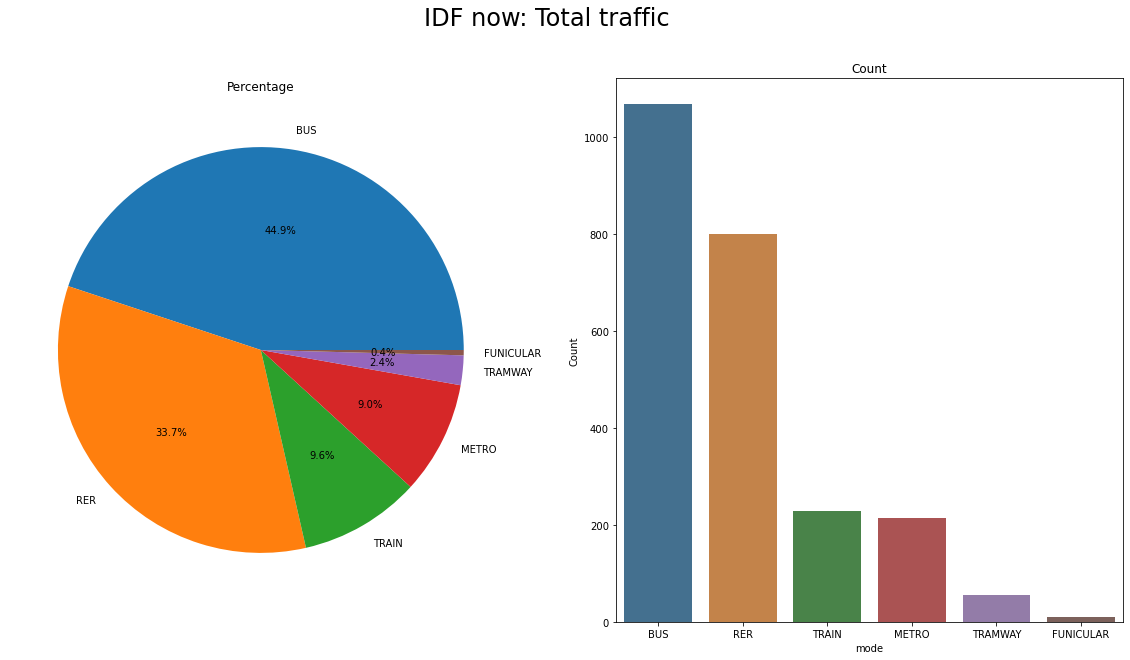

In [28]:
display_percentage_by_column("IDF now: Total traffic", "mode", df_modes_idf)

,Percentage,Count
13,14.95,32
9,12.62,27
4,12.15,26
14,11.21,24
5,10.75,23
1,8.88,19
7,7.01,15
6,5.14,11
2,4.67,10
8,4.67,10


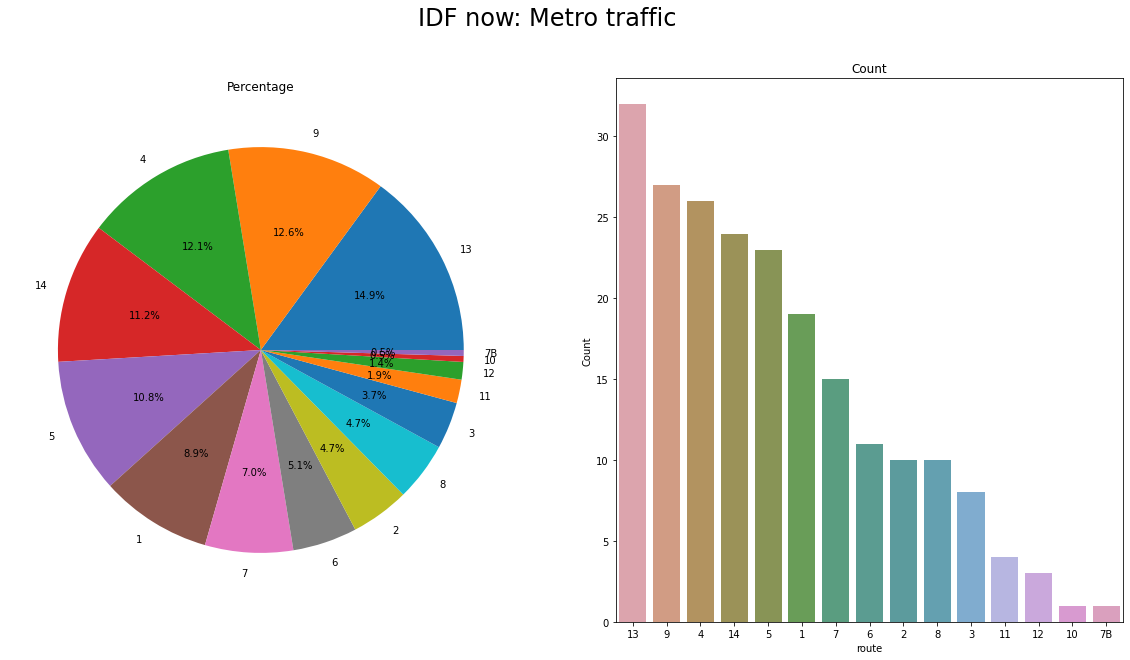

In [29]:
display_percentage_by_column("IDF now: Metro traffic", "route", df_modes_idf.loc[df_modes_idf["mode"] == "METRO"])

,Percentage,Count
A,33.00,264
B,32.38,259
D,16.12,129
C,11.88,95
E,6.62,53
Total,100.00,800


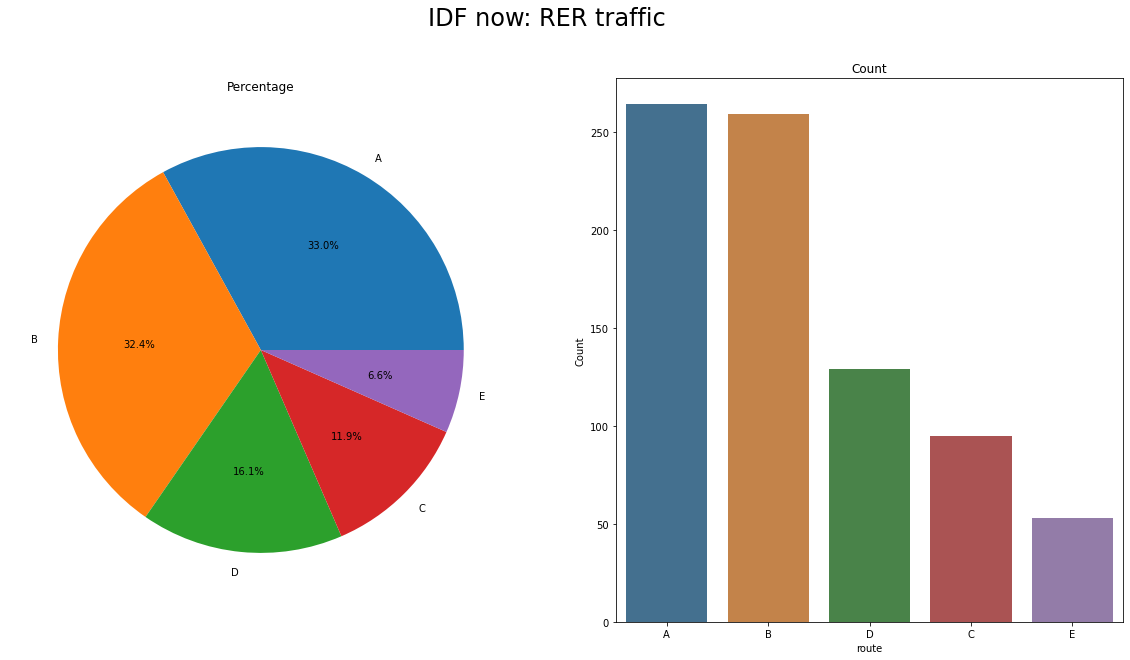

In [30]:
display_percentage_by_column("IDF now: RER traffic", "route", df_modes_idf.loc[df_modes_idf["mode"] == "RER"])

# IDF GPE

,Percentage,Count
BUS,38.63,1068
RER,26.80,741
METRO,22.86,632
TRAIN,9.73,269
TRAMWAY,1.74,48
FUNICULAR,0.14,4
RAIL,0.11,3
Total,100.00,2765


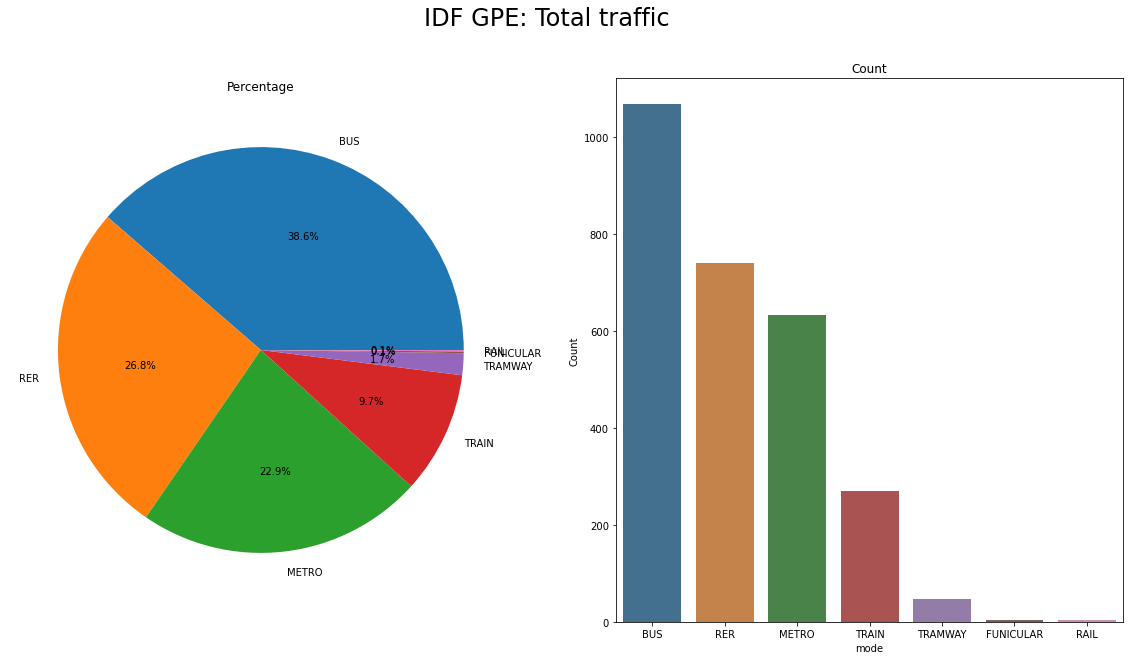

In [31]:
display_percentage_by_column("IDF GPE: Total traffic", "mode", df_modes_gpe_idf)

,Percentage,Count
15,35.76,226
16,11.87,75
14,10.60,67
15B,8.23,52
18,5.85,37
17,5.22,33
13,4.27,27
9,3.48,22
5,2.85,18
6,2.22,14


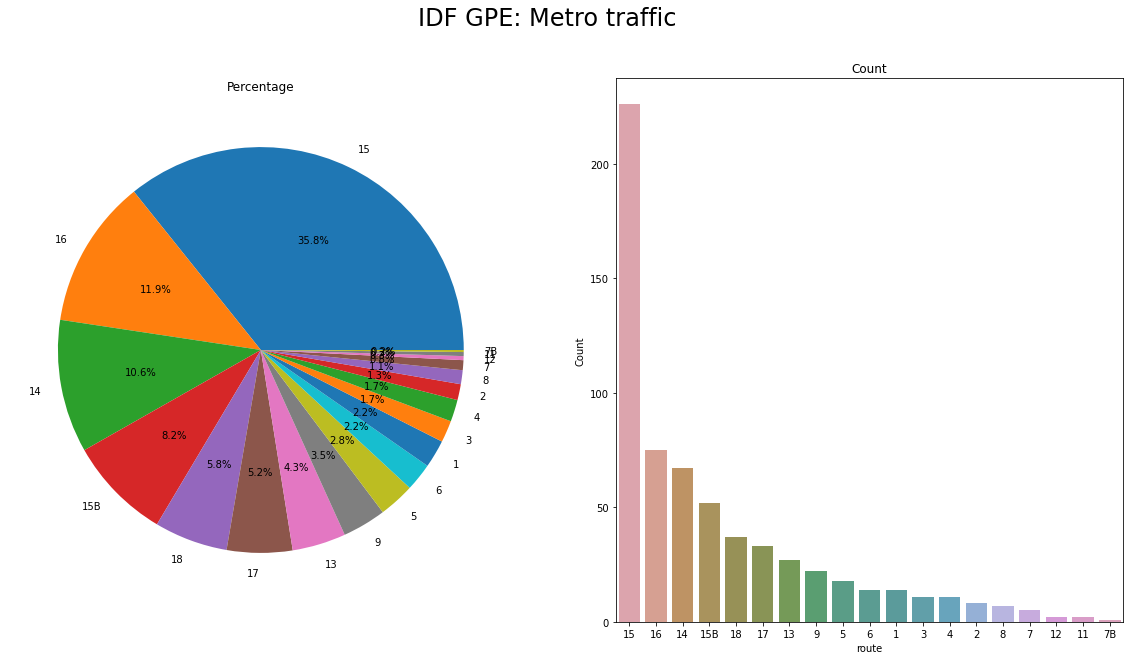

In [32]:
display_percentage_by_column("IDF GPE: Metro traffic", "route", df_modes_gpe_idf.loc[df_modes_gpe_idf["mode"] == "METRO"])

,Percentage,Count
A,36.98,274
B,27.26,202
C,16.87,125
D,14.17,105
E,4.72,35
Total,100.00,741


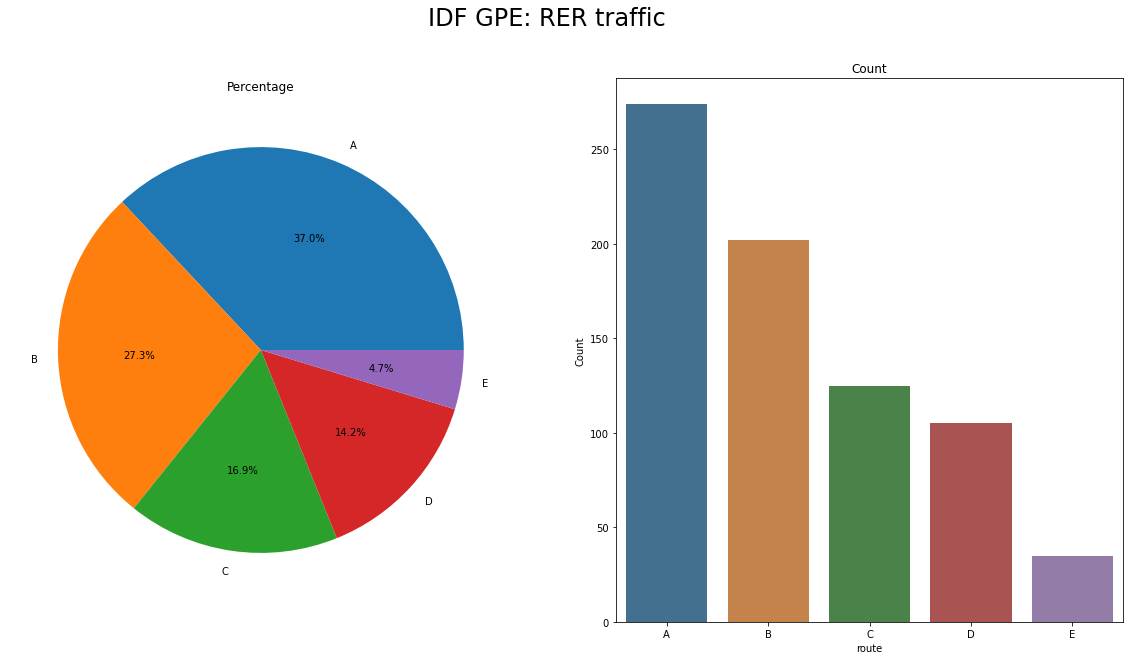

In [33]:
display_percentage_by_column("IDF GPE: RER traffic", "route", df_modes_gpe_idf.loc[df_modes_gpe_idf["mode"] == "RER"])

# Durations between Areas

In [34]:
def add_area(df_itineraries_):
    df_itineraries_["area"] = ""
    
    df_itineraries_.loc[(
        (df_itineraries_["origin"].map(lambda o: o["departement"] == "PARIS")) &
        (df_itineraries_["destination"].map(lambda d: d["departement"] == "PARIS"))
    ), "area"] = "PARIS,PARIS"
    
    df_itineraries_.loc[(
        (df_itineraries_["origin"].map(lambda o: not o["departement"] == "PARIS")) &
        (df_itineraries_["destination"].map(lambda d: not d["departement"] == "PARIS"))
    ), "area"] = "SUBURB,SUBURB"
    
    df_itineraries_.loc[(
        (
            (df_itineraries_["origin"].map(lambda o: not o["departement"] == "PARIS")) & 
            (df_itineraries_["destination"].map(lambda d: d["departement"] == "PARIS"))
        ) | (
            (df_itineraries_["origin"].map(lambda o: o["departement"] == "PARIS")) & 
            (df_itineraries_["destination"].map(lambda d: not d["departement"] == "PARIS"))
        )
    ), "area"] = "PARIS,SUBURB"
    
    return df_itineraries_
    
def plot_metrics_by_area(area):
    plot_metrics_by_epoch(
        df_itineraries_idf.loc[(df_itineraries_idf["area"] == area) & (df_itineraries_idf["mode"] == 'WALK,TRANSIT')],
        df_itineraries_gpe_idf.loc[(df_itineraries_gpe_idf["area"] == area) & (df_itineraries_gpe_idf["mode"] == 'WALK,TRANSIT')],
        area
    )

In [35]:
df_itineraries_idf = add_area(df_itineraries_idf)
df_itineraries_gpe_idf = add_area(df_itineraries_gpe_idf)

# PARIS - PARIS

,Trips found,Duration,Transfers,Distance,Walktime
epoch,,,,,
"PARIS,PARIS IDF now",7,2284.00,1.14,5.25,917.14
"PARIS,PARIS IDF GPE",7,2261.43,1.14,5.25,900.71


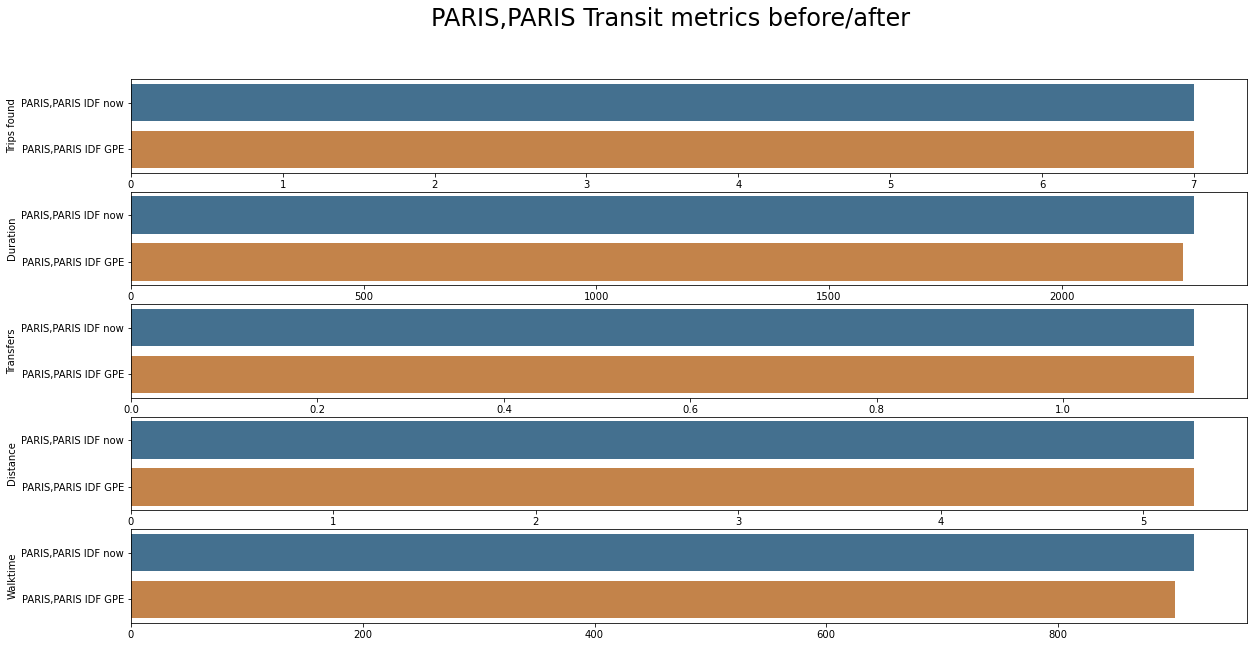

In [36]:
plot_metrics_by_area("PARIS,PARIS")

# PARIS - SUBURB

,Trips found,Duration,Transfers,Distance,Walktime
epoch,,,,,
"PARIS,SUBURB IDF now",102,4249.03,1.87,15.97,1231.34
"PARIS,SUBURB IDF GPE",115,4059.85,1.89,16.69,1342.97


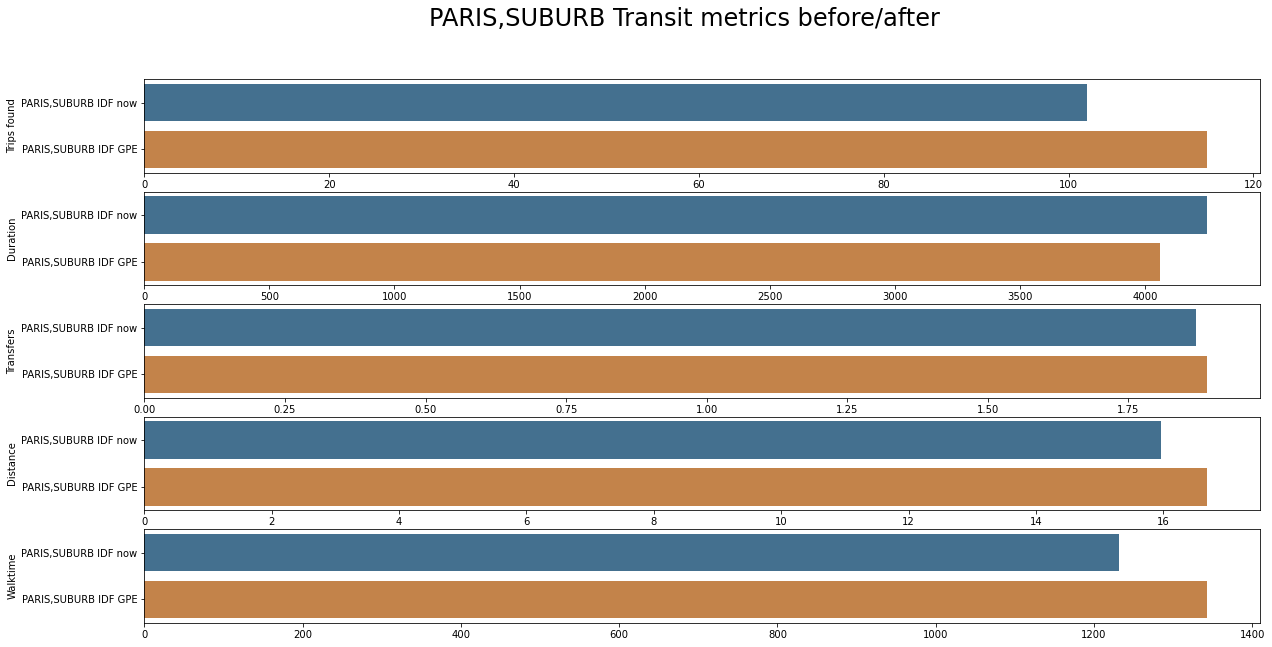

In [37]:
plot_metrics_by_area("PARIS,SUBURB")

# SUBURB - SUBURB

,Trips found,Duration,Transfers,Distance,Walktime
epoch,,,,,
"SUBURB,SUBURB IDF now",617,5263.56,2.36,18.52,1377.53
"SUBURB,SUBURB IDF GPE",753,4864.59,2.23,19.30,1568.29


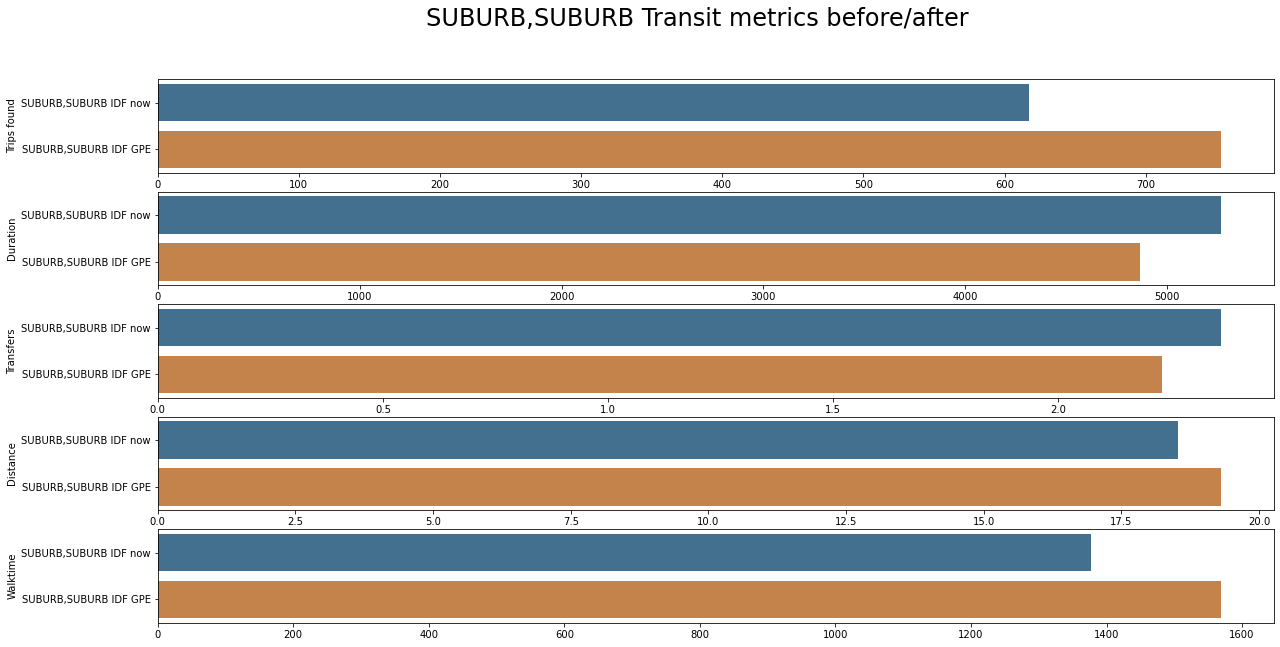

In [38]:
plot_metrics_by_area("SUBURB,SUBURB")

In [39]:
def add_area_departement(df_itineraries_):
    departements = [
        "PARIS",
        "SEINE-ET-MARNE",
        "YVELINES",
        "ESSONE",
        "HAUTS-DE-SEINE",
        "SEINE-SAINT-DENIS",
        "VAL-DE-MARNE",
        "VAL-D'OISE"
    ]

    combinations = list(itertools.combinations(departements, 2))
    for d in departements:
        combinations.append((d, d))
    
    df_itineraries_["area_departement"] = ""
    
    for c in combinations:
        df_itineraries_.loc[(
            (
                (df_itineraries_["origin"].map(lambda o: o["departement"] == c[0])) & 
                (df_itineraries_["destination"].map(lambda d: d["departement"] == c[1]))
            ) | (
                (df_itineraries_["origin"].map(lambda o: o["departement"] == c[1])) & 
                (df_itineraries_["destination"].map(lambda d: d["departement"] == c[0]))
            )
        ), "area_departement"] = f"{c[0]},{c[1]}"
    
    return df_itineraries_

In [40]:
df_itineraries_idf = add_area_departement(df_itineraries_idf)
df_itineraries_gpe_idf = add_area_departement(df_itineraries_gpe_idf)

In [41]:
def get_mean_duration_between_departements(df_itineraries_):
    return df_itineraries_[["duration", "area_departement"]].groupby("area_departement").mean().round(2) .sort_values("duration", ascending=False)

In [42]:
def plot_mean_duration_between_departements(df, title, y_):
    plt.figure(figsize=(20, 10))
    sns.barplot(x="area_departement", y=y_, data=df.reset_index(), saturation=.5)
    plt.xticks(rotation=90)
    plt.title(f'{title}', fontsize=24)
    None

In [43]:
df_duration = pd.concat([
    get_mean_duration_between_departements(df_itineraries_idf).rename(columns={'duration': 'duration_idf'}),
    get_mean_duration_between_departements(df_itineraries_gpe_idf).rename(columns={'duration': 'duration_gpe_idf'})
], axis=1)

df_duration["duration_improvement"] = - 100 * (df_duration["duration_gpe_idf"] - df_duration["duration_idf"]) / df_duration["duration_idf"]
df_duration = df_duration.sort_values("duration_improvement", ascending=False)
df_duration.index.names = ["area_departement"]
df_duration

,duration_idf,duration_gpe_idf,duration_improvement
area_departement,,,
"YVELINES,HAUTS-DE-SEINE",5195.27,3411.81,34.328533
"YVELINES,VAL-D'OISE",6986.69,5414.69,22.499925
"YVELINES,YVELINES",4265.50,3354.37,21.360450
"ESSONE,ESSONE",3932.08,3095.72,21.270167
"YVELINES,VAL-DE-MARNE",7101.66,5597.95,21.174064
"YVELINES,SEINE-SAINT-DENIS",6598.88,5381.49,18.448434
"PARIS,YVELINES",5349.38,4584.45,14.299414
"HAUTS-DE-SEINE,VAL-DE-MARNE",4509.84,4153.41,7.903385
"HAUTS-DE-SEINE,HAUTS-DE-SEINE",2962.36,2732.44,7.761379


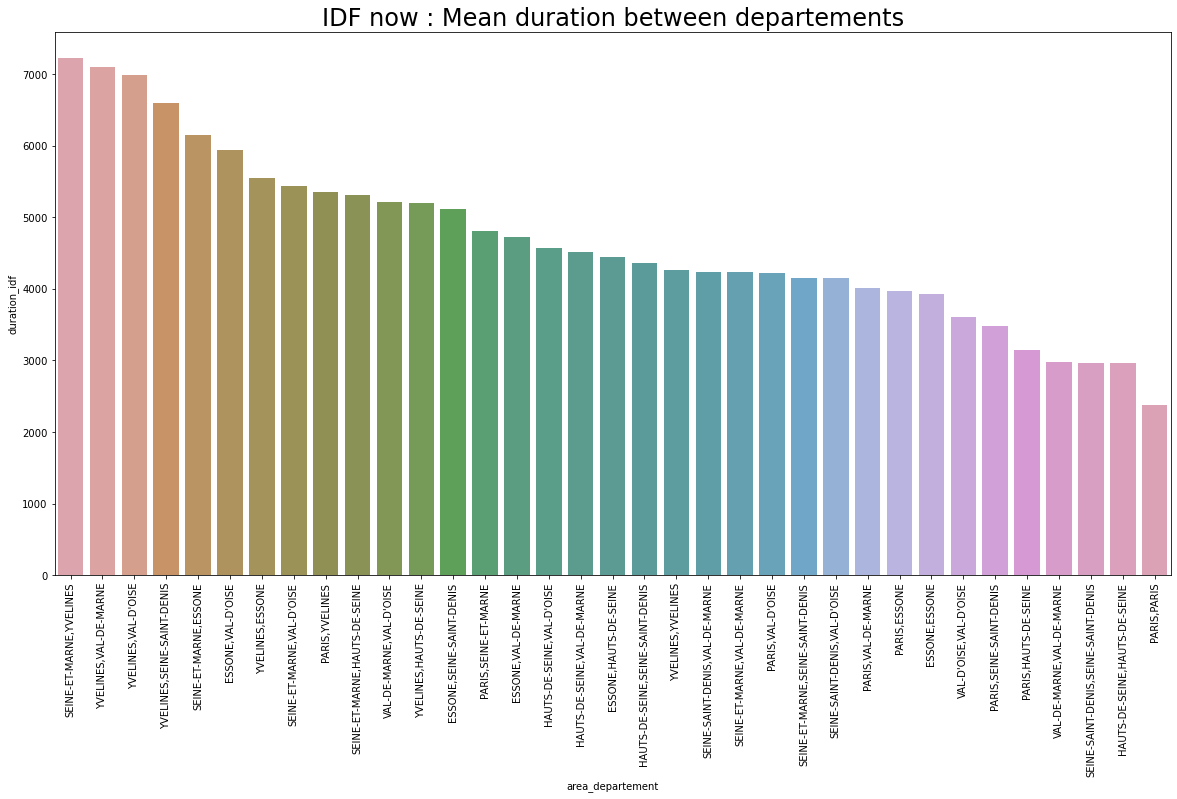

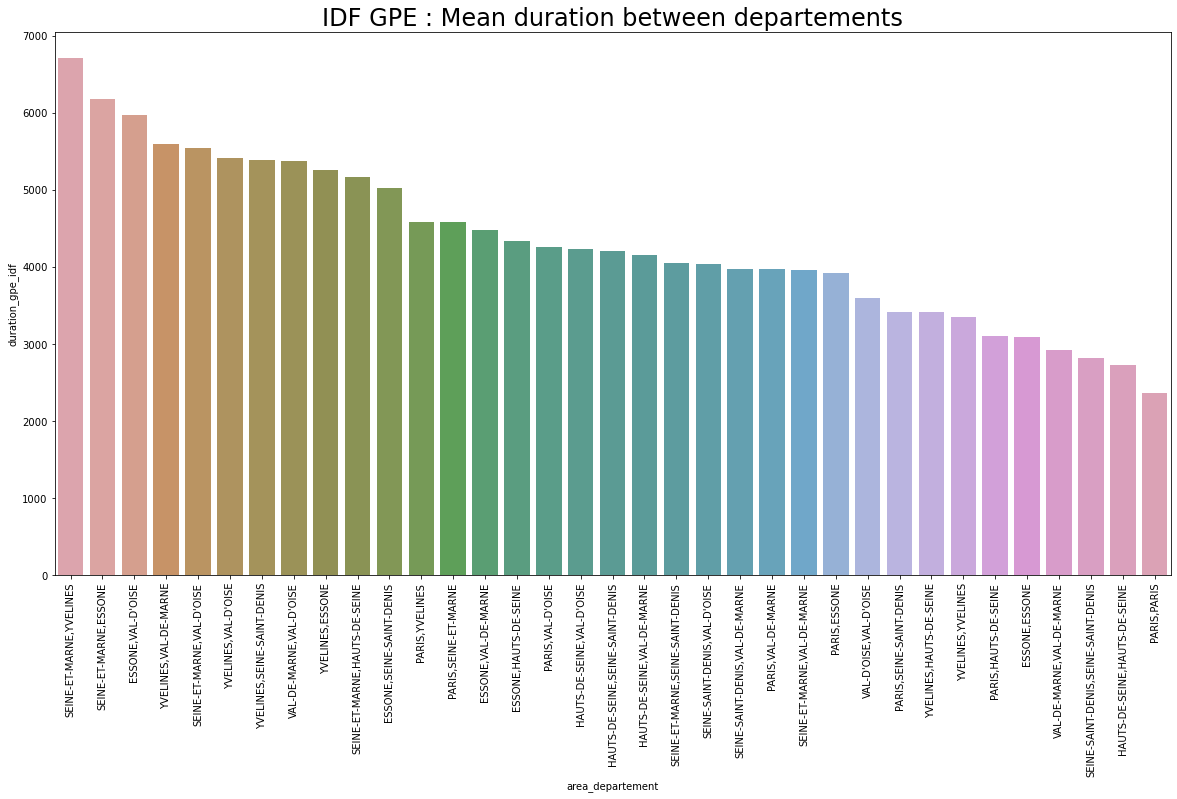

In [44]:
plot_mean_duration_between_departements(
    df_duration.loc[pd.isna(df_duration["duration_idf"]) == False].sort_values("duration_idf", ascending=False), 
    "IDF now : Mean duration between departements", 
    "duration_idf"
)

plot_mean_duration_between_departements(
    df_duration.loc[pd.isna(df_duration["duration_gpe_idf"]) == False].sort_values("duration_gpe_idf", ascending=False), 
    "IDF GPE : Mean duration between departements",
    "duration_gpe_idf"
)

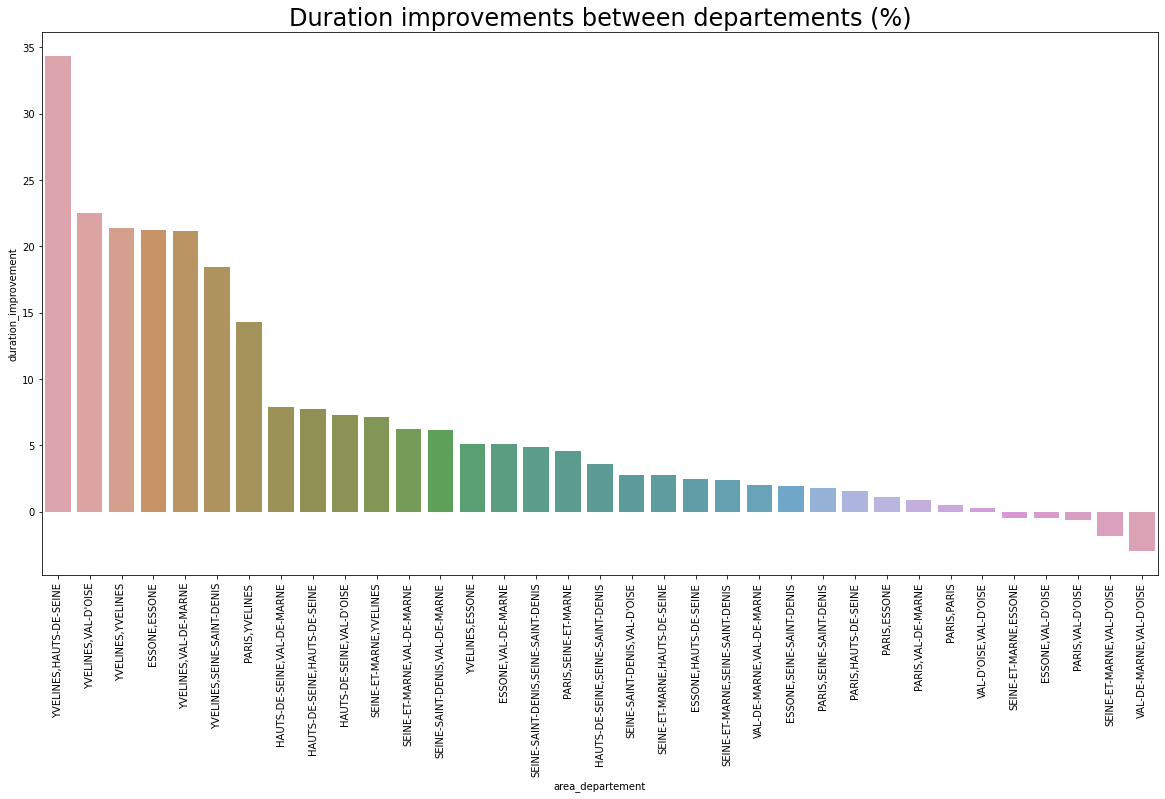

In [45]:
plot_mean_duration_between_departements(
    df_duration.loc[pd.isna(df_duration["duration_improvement"]) == False].sort_values("duration_improvement", ascending=False), 
    "Duration improvements between departements (%)",
    "duration_improvement"
)